# Crystallographic Identification of Single Layers in Quantum Materials with Arbitrary Substrates using Image Processing Techniques

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageColor
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from sklearn.cluster import KMeans
import argparse
import imutils
import math 
import io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab as pl
from PIL import Image
import numpy as np
import pylab
from colorsys import rgb_to_hsv

### Importing Images and Creating Image Paths and Directories

In [2]:
#Image Paths on my computer
WESE_Path='/Users/rohitganti/Desktop/Research/Luis Research/WSe2/'
Monolayer_Path='/Users/rohitganti/Desktop/Research/Luis Research/WSe2/Potential Monolayers'
Samples_Path='/Users/rohitganti/Desktop/Research/Luis Research/WSe2/Usable Samples'

#Creating the path directories for accessing these images easily for automation
WESE_Array=[]
for items in os.listdir(WESE_Path):
    if items[-4:-1]=='.jp':
        WESE_Array.append(WESE_Path+items)
    
Monolayer_Array=[]
for items in os.listdir(Monolayer_Path):
    Monolayer_Array.append(Monolayer_Path+ items)

Sample_Array=[]
for items in os.listdir(Samples_Path):
    Sample_Array.append(Samples_Path+items)

In [3]:
image_number= WESE_Array[8]
img_PIL= Image.open(image_number)
img_cv= cv2.imread(image_number, cv2.IMREAD_COLOR)

### Conversion Functions or Other Helper Functions

In [4]:
def fig2img(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def fig2data(fig):
    fig.canvas.draw()
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w,h,4)
    buf = np.roll(buf,3,axis=2)
    return buf

def fig2img2(fig):
    buf = fig2data(fig )
    w, h, d = buf.shape
    return Image.frombytes("RGBA", (w,h), buf.tostring( ) )




### Pixel by Pixel Functions

In [5]:
def count_pixels(filename):
    """
    This function counts all the pixels in the RGB value and returns the color count in an integers format
    and the color tuple in color array
    """
    color_count = {}
    with Image.open(filename) as image:
        width, height = image.size
        rgb_image = image.convert('RGB')
        for x in range(width):
            for y in range(height):
                rgb = rgb_image.getpixel((x, y))
                if rgb in color_count:
                    color_count[rgb] += 1
                else:
                    color_count[rgb] = 1
    color_array=[]
    for colors in color_count:
        color_array.append(colors)
    return color_count, color_array

In [6]:
def get_max(color_dict,color_array):
    """Returns the color value with the most number of pixes or the set background """
    new_max= color_dict[color_array[0]]
    color=color_array[0]
    for colors in color_dict:
        if int(color_dict[colors])> int(new_max):
            new_max= color_dict[colors]
            color= colors
    return color

In [7]:
def average_tuple(nums):
    """Gets an average value for the tuple colors"""
    result = [sum(x) / len(x) for x in zip(*nums)]
    tup_down= (math.floor(result[0]), math.floor(result[1]), math.floor(result[2]))
    tup_up= (math.ceil(result[0]), math.ceil(result[1]), math.ceil(result[2]))
    return tup_down, tup_up

In [8]:
def get_possible_backgrounds(color_dict, color_array):
    """Returns the top five abundant backgrounds in an image"""
    new_dict= color_dict.copy()
    first_back= get_max(new_dict, color_array)
    new_dict.pop(first_back)
    color_array.remove(first_back)
    second_back= get_max(new_dict, color_array)
    new_dict.pop(second_back)
    color_array.remove(second_back)
    third_back= get_max(new_dict, color_array)
    new_dict.pop(third_back)
    color_array.remove(third_back)
    fourth_back= get_max(new_dict,color_array)
    new_dict.pop(fourth_back)
    color_array.remove(fourth_back)
    fifth_back= get_max(new_dict, color_array)
    new_dict.pop(fifth_back)
    color_array.remove(fifth_back)
    all_tuples= first_back, second_back, third_back, fourth_back, fifth_back
    #total_similar_pixels= color_dict[first_back]+color_dict[second_back]+color_dict[third_back]+color_dict[fourth_back]+color_dict[fifth_back]
    return first_back,second_back,third_back,fourth_back,fifth_back

### Layer By Layer Function

The set of the following codes follows on the Heat Map which is generated by this following function:

In [9]:
def generate_heatmap(image_number):
    """
    This function is used to create and save 
    """
    img= Image.open(image_number).convert('L')
    z= np.asarray(img)
    mydata= z[::1,::1]
    fig= pl.figure(facecolor='w')
    ax1= fig.add_subplot(1,2,1)
    im= ax1.imshow(mydata, interpolation='nearest', cmap=pl.cm.jet)
    pl.xticks([])
    pl.yticks([])
    #pl.show()
    b= fig2img(fig)
    c=b.resize(img.size)
    d= c.convert('RGB')
    im= image_number.strip('.jpg')
    string= im+'heatmap.jpg'
    d.save(string)
    return string

## Approach 1

The following function is used to layer the heatmap and convert it to hsv space to give pixel to layer classification

In [40]:
layers= {
    (0,0,255): 'background blue 1',
    (51,51,255): 'background blue 2',
    (0,0,204): 'background blue 3',
    (0,128,255): 'layer 1',
    (0,102,204): 'layer 1 (2)',
    (51,153,255): 'layer 2',
    (102,178,255): 'layer 3',
    (153,204,255): 'layer 3 (2)',
    (0,255,255): 'layer 4',
    (51,255,255): 'layer 4 (1)',
    (102,255,255): 'layer 5',
    (153,255,255): 'layer 5(1)',
    (255,255,255): 'White background'
}

colors=layers
def to_hsv (color):
    "" "converts color tuples to floats and then to hsv" ""
    return rgb_to_hsv (* [x/255.0 for x in color]) 

def color_dist (c1, c2):
    "" "returns the squared euklidian distance between two color vectors in hsv space" ""
    return sum ((a-b) ** 2 for a, b in zip (to_hsv (c1), to_hsv (c2)))

def min_color_diff (color_to_match, colors):
    "" "returns the` (distance, color_name) `with the minimal distance to` colors` "" "
    return min ((color_dist (color_to_match, test), colors[test]) for test in colors)

Example of the approach 1 by layering function to function

Getting number of pixels per RGB value in the image

{(255, 255, 255): 5098552,
 (254, 254, 252): 43,
 (255, 255, 253): 360,
 (254, 254, 255): 1668,
 (255, 254, 255): 1495,
 (254, 253, 255): 222,
 (253, 252, 255): 7,
 (253, 253, 255): 16,
 (254, 252, 255): 274,
 (251, 255, 255): 48,
 (252, 251, 255): 5,
 (254, 254, 254): 137,
 (254, 255, 250): 67,
 (254, 255, 249): 850,
 (255, 255, 250): 692,
 (255, 255, 248): 181,
 (254, 255, 245): 2,
 (252, 254, 243): 1,
 (253, 253, 251): 9,
 (254, 255, 255): 2798,
 (252, 255, 255): 48,
 (254, 255, 247): 1,
 (251, 255, 249): 32,
 (255, 255, 246): 1006,
 (255, 255, 244): 742,
 (254, 255, 243): 120,
 (254, 255, 244): 24,
 (253, 255, 243): 8,
 (255, 255, 251): 55,
 (252, 252, 254): 7,
 (252, 252, 250): 7,
 (253, 253, 253): 34,
 (251, 251, 253): 5,
 (252, 252, 252): 8,
 (249, 249, 247): 3,
 (246, 246, 244): 2,
 (248, 248, 246): 2,
 (243, 243, 241): 3,
 (237, 237, 235): 3,
 (235, 235, 233): 2,
 (236, 236, 234): 2,
 (239, 239, 237): 740,
 (239, 239, 239): 21,
 (238, 238, 236): 120,
 (240, 239, 237): 24,
 (23

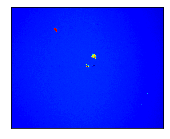

In [41]:
heat_loc=generate_heatmap(image_number)
heat_dict, heat_vals= count_pixels(heat_loc)
heat_dict

In [42]:
# only have the blue pixels or their related shades for identifying the single layers potentials
blue_dict={}
threshold=10
for col in heat_dict:
    if col[2]== 255 or col[2]==205:
        if col[1]>= 190- threshold or col[1]<= 190+threshold:
            blue_dict[col]= heat_dict[col]

blue_dict1={}
restrict=[i for i in range(200,255)]
for col in blue_dict:
    if col[0] not in restrict:
        blue_dict1[col]= blue_dict[col]

blue_dict1

{(255, 255, 255): 5098552,
 (255, 254, 255): 1495,
 (196, 194, 205): 860,
 (199, 193, 205): 32,
 (4, 8, 255): 50,
 (5, 11, 255): 48,
 (2, 1, 255): 342,
 (0, 2, 255): 968,
 (1, 1, 255): 8489,
 (4, 15, 255): 125,
 (2, 6, 255): 241,
 (3, 12, 255): 132,
 (3, 7, 255): 121,
 (5, 9, 255): 32,
 (4, 13, 255): 24,
 (5, 4, 255): 23,
 (3, 9, 255): 102,
 (2, 13, 255): 688,
 (1, 9, 255): 2419,
 (1, 4, 255): 1810,
 (3, 6, 255): 398,
 (3, 11, 255): 822,
 (2, 10, 255): 1878,
 (3, 8, 255): 669,
 (3, 4, 255): 185,
 (2, 7, 255): 1160,
 (4, 5, 255): 94,
 (5, 6, 255): 28,
 (1, 6, 255): 1724,
 (6, 8, 205): 1,
 (3, 0, 255): 69,
 (0, 8, 255): 3209,
 (0, 3, 255): 1671,
 (1, 11, 255): 3753,
 (0, 10, 255): 2950,
 (0, 7, 255): 2682,
 (0, 5, 255): 1599,
 (2, 5, 255): 730,
 (1, 13, 255): 6315,
 (0, 14, 255): 9474,
 (3, 14, 255): 502,
 (4, 4, 255): 166,
 (3, 3, 255): 974,
 (2, 17, 255): 3148,
 (2, 12, 255): 1978,
 (4, 16, 255): 144,
 (3, 15, 255): 865,
 (2, 14, 255): 4510,
 (4, 7, 255): 190,
 (2, 2, 255): 8557,
 (0, 

In [43]:
for color_to_match in blue_dict1:
    print(min_color_diff(color_to_match, colors))

(0.0, 'White background')
(0.21937812379853905, 'layer 3 (2)')
(0.17131238367020563, 'layer 3 (2)')
(0.1828217925609081, 'layer 3 (2)')
(0.00025311376974109233, 'background blue 1')
(0.0004004675124951958, 'background blue 1')
(1.580925691647614e-05, 'background blue 1')
(1.7087444999786286e-06, 'background blue 1')
(1.5378700499807656e-05, 'background blue 1')
(0.0002994093311872069, 'background blue 1')
(6.845827001848439e-05, 'background blue 1')
(0.00017383914350053623, 'background blue 1')
(0.00014540698874562996, 'background blue 1')
(0.0003915786236063065, 'background blue 1')
(0.00028177292682678227, 'background blue 1')
(0.0002465001181059331, 'background blue 1')
(0.00015415534405483215, 'background blue 1')
(0.00011402477889484126, 'background blue 1')
(4.293431116658367e-05, 'background blue 1')
(1.9253708249823142e-05, 'background blue 1')
(0.00014234506438740973, 'background blue 1')
(0.0001664030414877143, 'background blue 1')
(8.928867407624686e-05, 'background blue 1')

Once we have created a pixel by pixel classification of the layers we can represent the data in a dataframe

In [44]:
dict_df={
    "Layer":[],
    "Pixel RGB Value":[],
    "Number of Pixels": []
}
for color_to_match in blue_dict:
    dict_df["Layer"].append(min_color_diff(color_to_match, colors)[1])
    dict_df["Pixel RGB Value"].append(color_to_match)
    dict_df["Number of Pixels"].append(blue_dict[color_to_match])
    
df= pd.DataFrame(dict_df)
df

,Layer,Pixel RGB Value,Number of Pixels
0,White background,"(255, 255, 255)",5098552
1,layer 3 (2),"(254, 254, 255)",1668
2,layer 3 (2),"(255, 254, 255)",1495
3,layer 3 (2),"(254, 253, 255)",222
4,layer 3 (2),"(253, 252, 255)",7
...,...,...,...
719,background blue 1,"(10, 59, 255)",1
720,background blue 1,"(10, 57, 255)",1
721,layer 3 (2),"(252, 253, 255)",19
722,layer 3 (2),"(203, 203, 205)",1


## Approach 2

Image Derivative functions

In [10]:
def laplacian(image_number):
    imag= cv2.imread(image_number,cv2.IMREAD_COLOR)
    b,g,r= cv2.split(imag)
    image=cv2.merge([r,g,b])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray,(3,3),0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    #plt.title('Laplacian')
    plt.xticks([])
    plt.yticks([])
    string= image_number+'_Laplacian.jpg'
    plt.imshow(laplacian, cmap='gray')
    plt.savefig(string)
    return string

def sobelx(image_number):
    imag= cv2.imread(image_number,cv2.IMREAD_COLOR)
    b,g,r= cv2.split(imag)
    image=cv2.merge([r,g,b])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray,(3,3),0)
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    plt.title('SobelX')
    plt.xticks([])
    plt.yticks([])
    string= image_number+'_SobelX.jpg'
    plt.imshow(sobelx, cmap='gray')
    plt.savefig(string)
    return string

def sobely(imag):
    imag= cv2.imread(imag,cv2.IMREAD_COLOR)
    b,g,r= cv2.split(imag)
    image=cv2.merge([r,g,b])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray,(3,3),0)
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    plt.title('SobelY')
    #plt.xticks([])
    #plt.yticks([])
    string= image_number+'_SobelY.jpg'
    plt.imshow(sobely, cmap='gray')
    plt.imshow(sobely)
    plt.savefig(string)
    return string


The following code is to show the 3 image derivative techniques

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


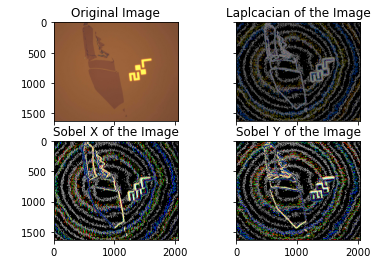

In [73]:
image_number='186503079_981061809099190_7228838060409850774_n.jpg'
imag= cv2.imread(image_number, cv2.IMREAD_COLOR)
b,g,r= cv2.split(imag)
image= cv2.merge([r,g,b])
gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img= cv2.GaussianBlur(gray, (3,3),0)
laplacian= cv2.Laplacian(image, cv2.CV_64F)
sobelx= cv2.Sobel(image,cv2.CV_64F,1,0, ksize=5)
sobely= cv2.Sobel(image,cv2.CV_64F,0,1, ksize=5)
fig, axs=plt.subplots(2,2)
axs[0,0].imshow(image)
axs[0,0].set_title('Original Image')
axs[0,1].imshow(laplacian, cmap='gray')
axs[0,1].set_title('Laplcacian of the Image')
axs[1,0].imshow(sobelx, cmap='gray')
axs[1,0].set_title('Sobel X of the Image')
axs[1,1].imshow(sobely, cmap='gray')
axs[1,1].set_title('Sobel Y of the Image')
for ax in axs.flat:
    ax.set(xlabel=' ', ylabel=' ')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.show()

### Piece Information Statistics

In [11]:
def get_number_of_pieces(image_number):
    image= cv2.imread(sobely(image_number))
    gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    edges= cv2.Canny(gray,threshold1=300, threshold2=500)
    contours, hierarchy= cv2.findContours(edges.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return len(contours)

In [20]:
def generate_pieces(image_number):
    image= cv2.imread(sobely(image_number))
    gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    edges= cv2.Canny(gray,threshold1=300, threshold2=500)
    contours, hierarchy= cv2.findContours(edges.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    pieces_data={
        "Piece_Number":[],
        "Area":[],
        "Perimeter":[],
        "Approximation":[],
        "Convexity":[]
    }
    count=1
    for i in contours:
        pieces_data["Piece_Number"].append(count)
        pieces_data["Area"].append(cv2.contourArea(i))
        pieces_data["Perimeter"].append(cv2.arcLength(i,True))
        pieces_data["Approximation"].append(cv2.approxPolyDP(i,0.1*cv2.arcLength(i,True),True))
        pieces_data["Convexity"].append(cv2.isContourConvex(i))
        count=count+1
    material_data=pd.DataFrame(pieces_data)
    return material_data

In [21]:
def filter_pieces_by_convexity(material_data):
    material_data1= material_data.loc[material_data['Area']!=0.0]
    material_data2= material_data1.loc[material_data1['Convexity']==True]
    return material_data2

In [22]:
def filter_pieces_by_concavity(material_data):
    material_data1= material_data.loc[material_data['Area']!=0.0]
    material_data2= material_data1.loc[material_data1['Convexity']!=True]
    return material_data2

Application of single layer data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of pieces in the single layer:  55


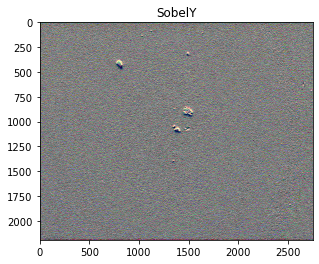

In [23]:
print("Number of pieces in the single layer: ", get_number_of_pieces(image_number))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


,Piece_Number,Area,Perimeter,Approximation,Convexity
0,1,0.0,9.656854,"[[[212, 266]], [[213, 267]], [[216, 266]], [[2...",False
1,2,0.5,6.242641,"[[[345, 263]], [[343, 265]], [[345, 264]]]",False
2,3,1.5,26.727922,"[[[182, 262]], [[185, 267]]]",False
3,4,8.0,11.656854,"[[[348, 260]], [[348, 265]]]",False
4,5,8.0,11.656854,"[[[214, 260]], [[214, 265]]]",False
...,...,...,...,...,...
61,62,0.0,4.828427,"[[[226, 23]], [[228, 24]]]",False
62,63,0.0,0.000000,"[[[214, 22]]]",False
63,64,22.0,72.284271,"[[[231, 19]], [[238, 28]], [[241, 20]], [[237,...",False
64,65,47.5,82.183766,"[[[216, 19]], [[229, 29]]]",False


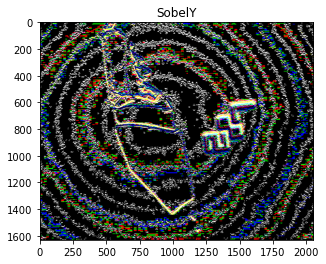

In [24]:
generate_pieces('186503079_981061809099190_7228838060409850774_n.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


,Piece_Number,Area,Perimeter,Approximation,Convexity


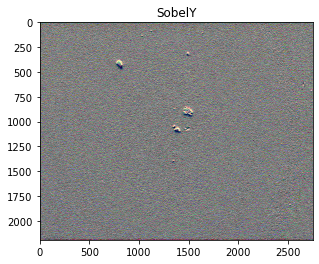

In [25]:
filter_pieces_by_convexity(generate_pieces(image_number))
#therefore no piece with a convext crystallographic shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


,Piece_Number,Area,Perimeter,Approximation,Convexity
1,2,0.5,6.242641,"[[[276, 263]], [[274, 265]], [[276, 264]]]",False
2,3,8.0,11.656854,"[[[279, 260]], [[279, 265]]]",False
3,4,8.0,11.656854,"[[[180, 260]], [[180, 265]]]",False
4,5,8.0,11.656854,"[[[134, 260]], [[134, 265]]]",False
5,6,2.0,46.970562,"[[[126, 259]], [[126, 267]], [[136, 266]], [[1...",False
6,7,95.0,45.798990,"[[[331, 262]], [[345, 264]], [[343, 258]]]",False
7,8,18.0,88.426406,"[[[321, 259]], [[331, 266]]]",False
8,9,99.0,40.970562,"[[[283, 259]], [[284, 267]], [[294, 266]], [[2...",False
9,10,3.5,66.526911,"[[[271, 259]], [[281, 266]]]",False
10,11,95.0,45.798990,"[[[231, 262]], [[245, 264]], [[243, 258]]]",False


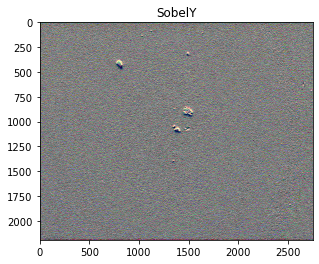

In [26]:
filter_pieces_by_concavity(generate_pieces(image_number)) #gets the number of pieces with a concave crystallographic structure